In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt

from pprint import  pprint
from fake_useragent import  UserAgent
from src.data_fetcher.client import  PriceHistory

# Set display options for  pandas
pd.set_option('display.max_colwidth', 1)
pd.set_option('expand_frame_repr', False)

## Fetching and Loading Data

In [2]:
# Define the symbols
symbols = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOGL']

# Grab number of stocks in portfolio
number_of_stocks = len(symbols)

# If no data is available, grab it from the NASDAQ.
if not pathlib.Path('src/data/stock_data.csv').exists():
    # Initialize PriceHistory Client
    price_history_client = PriceHistory(symbols=symbols, user_agent=UserAgent().chrome)
    # Grab and dump data in to a csv file.
    price_history_client.price_data_frame.to_csv('src/data/stock_data.csv', index=False)
    pprint(price_history_client.price_data_frame)
    
    # store dataframe in variable
    price_df: pd.DataFrame = price_history_client.price_data_frame
    
else:
    # load the existing CSV file
    price_df: pd.DataFrame = pd.read_csv('src/data/stock_data.csv')
    
display(price_df.head())

,date,close,volume,open,high,low,symbol
0,2025-04-03,178.41,95553620,182.995,184.13,176.920,AMZN
1,2025-04-02,196.01,53679200,187.660,198.34,187.660,AMZN
2,2025-04-01,192.17,41267320,187.860,193.93,187.200,AMZN
3,2025-03-31,190.26,63547560,188.190,191.33,184.400,AMZN
4,2025-03-28,192.72,52548230,198.420,199.26,191.881,AMZN


In [3]:
# Grab important columns
price_df = price_df[['date', 'symbol', 'close']]

# Pivot dataframe to make symbols headers
price_df = price_df.pivot(index='date', columns='symbol', values='close')

display(price_df.head())

symbol,AAPL,AMZN,MSFT,TSLA
date,,,,
2024-10-07,221.69,180.80,409.54,240.83
2024-10-08,225.77,182.72,414.71,244.50
2024-10-09,229.54,185.17,417.46,241.05
2024-10-10,229.04,186.65,415.84,238.77
2024-10-11,227.55,188.82,416.32,217.80


## Calculating Sharpe Ratio and Other Metrics

In [4]:
# Calculate log returns
log_return = np.log(1 + price_df.pct_change())

# Generate random weights and rebalance so that they sum up to 1
random_weights = np.array(np.random.random(number_of_stocks))
rebalance_weights = random_weights / np.sum(random_weights)

# Calculate expected returns annualized
exp_ret = np.dot(log_return.mean(), rebalance_weights) * 252

# Calculate expected volatility annualized
exp_vol  = np.sqrt(
    np.dot(rebalance_weights.T, np.dot(log_return.cov() * 252, rebalance_weights))
)
# Calculate Sharpe Ratio.
sharpe_ratio = (exp_ret - .02)/ exp_vol

In [5]:
weights_df = pd.DataFrame(data={
    'random_weights':random_weights,
    'rebalance_weights':rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print(weights_df)
print('-'*80)

metrics_df = pd.DataFrame(data={
    'Expected Portfolio Return': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])
print('')
print('='*80)
print('PORTFOLIO METRICS:')
print(metrics_df)
print('-'*80)



PORTFOLIO WEIGHTS:
   random_weights  rebalance_weights
0  0.886757        0.607630         
1  0.286025        0.195992         
2  0.081317        0.055721         
3  0.205270        0.140657         
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
   Expected Portfolio Return  Expected Portfolio Volatility  Portfolio Sharpe Ratio
0 -0.095202                   0.275689                      -0.41787               
--------------------------------------------------------------------------------


## Monte Carlo Simulation

In [6]:
# Number of simulations
num_of_simulations = 3000

all_weights = np.zeros((num_of_simulations, number_of_stocks))

return_arr = np.zeros(num_of_simulations)

vol_arr = np.zeros(num_of_simulations)

sharpe_arr = np.zeros(num_of_simulations)

for idx in range(num_of_simulations):
    weights = np.array(np.random.random(number_of_stocks))
    weights = weights / np.sum(weights)
    
    all_weights[idx,:] = weights
    
    return_arr[idx] = np.dot(log_return.mean(), weights) * 252
    
    vol_arr[idx] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))
    
    sharpe_arr[idx] = (return_arr[idx] -.01) / vol_arr[idx]
    
simulations_data = [return_arr, vol_arr, sharpe_arr, all_weights]

simulations_df = pd.DataFrame(data=simulations_data).T
simulations_df.columns = ['Returns','Volatility', 'Sharpe Ratio', 'Portfolio Weights']

simulations_df = simulations_df.infer_objects()

print('')
print('='*80)
print('SIMULATIONS DATA:')
print('='*80)
print(simulations_df.head())
print('-'*80)


SIMULATIONS DATA:
    Returns  Volatility  Sharpe Ratio                                                                     Portfolio Weights
0  0.002655  0.407436   -0.018026      [0.40934195610071383, 0.059489300472865735, 0.0891945833403048, 0.4419741600861156] 
1 -0.060562  0.310627   -0.227160      [0.051174754055969385, 0.18529809023591898, 0.5165932241101474, 0.24693393159796426]
2 -0.084590  0.260841   -0.362635      [0.2420504482883603, 0.495555043577305, 0.20575390486734585, 0.05664060326698894]   
3 -0.086688  0.277480   -0.348449      [0.2902706460086259, 0.15372560666556492, 0.367676469803717, 0.1883272775220922]    
4 -0.088992  0.272917   -0.362720      [0.34092036538435583, 0.17378404648781498, 0.3122824027232526, 0.1730131854045767]  
--------------------------------------------------------------------------------


## Grab Most Important metrics

In [7]:
# Grab max sharpe ratio
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

# Get min volatility
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns              0.164962                                                                            
Volatility           0.666956                                                                            
Sharpe Ratio         0.232342                                                                            
Portfolio Weights    [0.1065946987042659, 0.018665927565192128, 0.008883089751219795, 0.8658562839793221]
Name: 1992, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns             -0.186013                                                                             
Volatility           0.217971                                                                             
Sharpe Ratio        -0.899261                            

## Visualization

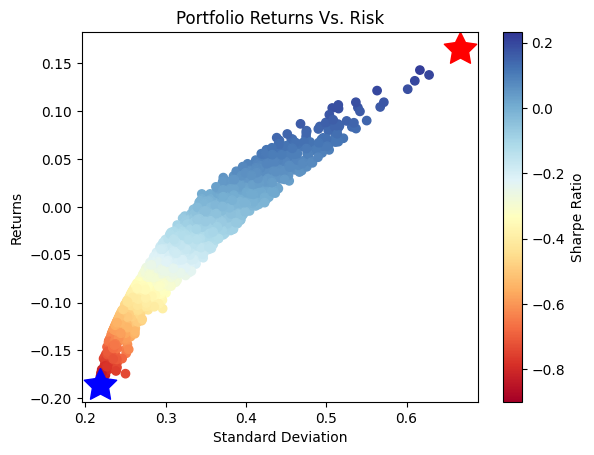

In [8]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Plot the data on a Scatter plot.
plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the Max Sharpe Ratio, using a `Red Star`.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

# Plot the Min Volatility, using a `Blue Star`.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color='b',
    s=600
)

# Finally, show the plot.
plt.show()

## Optimization

In [9]:
def get_metrics(weights: list) -> np.array:
    """
    ### Overview:
    ----
    With a given set of weights, return the portfolio returns,
    the portfolio volatility, and the portfolio sharpe ratio.
    
    ### Arguments:
    ----
    weights (list): An array of portfolio weights.
    
    ### Returns:
    ----
    (np.array): An array containg return value, a volatility value,
    and a sharpe ratio.
    """
    weights = np.array(weights)
     
    ret = np.dot(log_return.mean(), weights) * 252
     
    vol = np.sqrt(
            np.dot(weights.T, np.dot(log_return.cov() * 252 , weights))
            )
     
    sr = (ret - 0.02)/ vol
     
    return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[2] - 1

def grab_volatility(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    """Ensure the allocations of the "weights", sums to 1 (100%)

    ### Arguments:
    ----
    weights (list): The weights we want to check to see
        if they sum to 1.

    ### Returns:
    ----
    float: The different between 1 and the sum of the weights.
    """
    return np.sum(weights) - 1

In [10]:
# Define bounds in our optimization process. Make sure that no asset is more than 100% of portfolio
bounds = tuple((0, 1) for symbol in range(number_of_stocks))

# Define constraints, make sure weights don't exceed 100%
constraints = ({'type':'eq', 'fun': check_sum})

init_guess = number_of_stocks * [1 / number_of_stocks]

# Peform optimization process
optimized_sharpe = opt.minimize(
    grab_negative_sharpe, # minimize this
    init_guess, # start with this values
    method='SLSQP',
    bounds=bounds,# don't exceed these bounds
    constraints=constraints # don't exceed 100% constraints
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)



OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.9596449395818092
       x: [ 3.371e-01  3.590e-14  6.629e-01  8.646e-14]
     nit: 5
     jac: [ 9.216e-02  8.868e-01  9.217e-02  2.437e+00]
    nfev: 25
    njev: 5
--------------------------------------------------------------------------------


In [11]:
# Grab the final results
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)   


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[3.37118369e-01 3.59025418e-14 6.62881631e-01 8.64613828e-14]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[-0.1882376   0.21699443 -0.95964494]
--------------------------------------------------------------------------------


In [12]:
# Define bounds in our optimization process. Make sure that no asset is more than 100% of portfolio
bounds = tuple((0, 1) for symbol in range(number_of_stocks))

# Define constraints, make sure weights don't exceed 100%
constraints = ({'type':'eq', 'fun': check_sum})

init_guess = number_of_stocks * [1 / number_of_stocks]

# Peform optimization process
optimized_volatility = opt.minimize(
    grab_volatility, # minimize this
    init_guess, # start with this values
    method='SLSQP',
    bounds=bounds,# don't exceed these bounds
    constraints=constraints # don't exceed 100% constraints
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED VOLATILITY:')
print('-'*80)
print(optimized_volatility)
print('-'*80)



OPTIMIZED VOLATILITY:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.21674049884577784
       x: [ 3.762e-01  4.424e-17  6.238e-01  0.000e+00]
     nit: 7
     jac: [ 2.167e-01  2.280e-01  2.168e-01  3.266e-01]
    nfev: 35
    njev: 7
--------------------------------------------------------------------------------


In [13]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_volatility.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_volatility.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[3.76170259e-01 4.42354486e-17 6.23829741e-01 0.00000000e+00]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[-0.18775178  0.2167405  -0.95852773]
--------------------------------------------------------------------------------
